In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

data = pd.read_csv('data/inputs/fredmd_transf.csv')

plt.style.use("ggplot")

In [8]:
from learning.memory import run_memory, compute_transition_matrix

# fix dates
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")

# compute moving average
data = data.rolling(window=12).mean()

# drop missing values
data = data.dropna()

memory = run_memory(data=data,
                    fix_start=True,
                    estimation_window=12 * 4,
                    k_opt_method=None,
                    clustering_method="kmeans")

Building memory using window: 295: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s]


## 1) Regime changes for a given day

In [10]:
memory.head()

,cluster_step0,cluster_step1,cluster_step2,cluster_step3,cluster_step4,cluster_step5,cluster_step6,cluster_step7,cluster_step8,cluster_step9,...,cluster_step286,cluster_step287,cluster_step288,cluster_step289,cluster_step290,cluster_step291,cluster_step292,cluster_step293,cluster_step294,cluster_step295
date,,,,,,,,,,,,,,,,,,,,,
1993-02-01,5.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3
1993-03-01,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3
1993-04-01,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3
1993-05-01,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3
1993-06-01,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


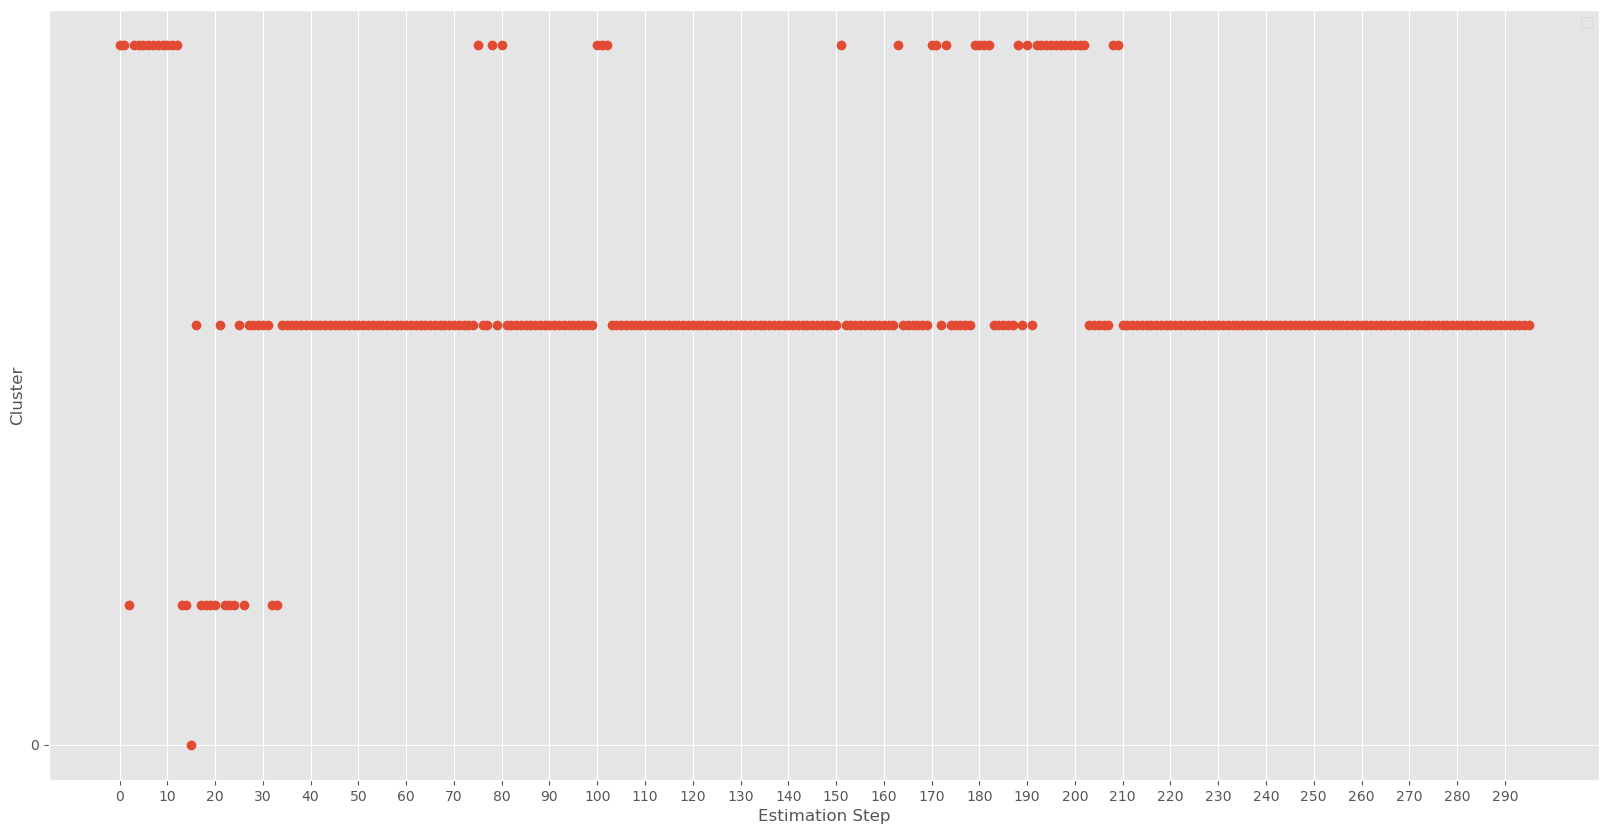

In [13]:
day_memory = pd.DataFrame(memory.iloc[0, :])
day_memory.index = [int(i.split('_')[-1].replace('step', '')) for i in day_memory.index]

plt.figure(figsize=(20, 10))
plt.plot(day_memory.index, day_memory.values, marker="o", linestyle="")
plt.xlabel("Estimation Step")
plt.ylabel("Cluster")

# Convert the index to integers and set the locations of the xticks
plt.xticks(np.arange(min(day_memory.index), max(day_memory.index)+1, 10))

# Set the locations of the yticks
plt.yticks(np.arange(min(day_memory.values), max(day_memory.values)+1, 10))

plt.grid(True)
plt.legend()

## 2) Plot regimes over time

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

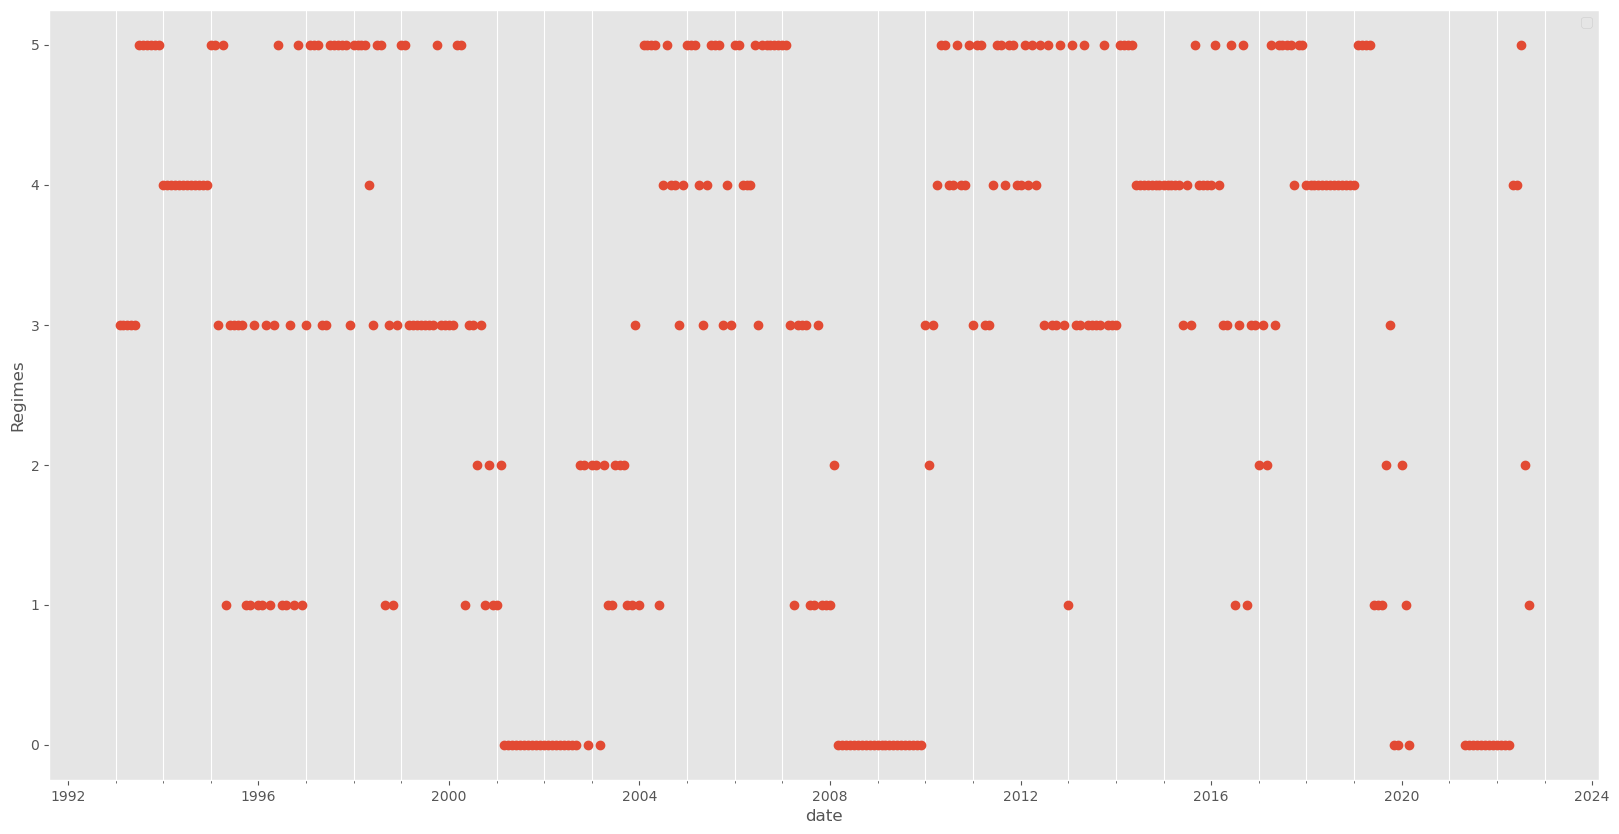

In [14]:
final_clusters = memory['cluster_step295']

plt.clf()
plt.figure(figsize=(20, 10))
plt.plot(final_clusters.index, final_clusters.values, marker="o", linestyle="")
ax = plt.gca()
ax.xaxis.set_minor_locator(mdates.YearLocator())
plt.xlabel("date")
plt.ylabel("Regimes")
plt.grid(which="both")
plt.legend()

## 3) Economic and financial statistics by regime

In [82]:
raw_data = pd.read_csv('data/inputs/fredmd_raw.csv')
raw_data["date"] = pd.to_datetime(raw_data["date"])
raw_data = raw_data.set_index("date")

raw_data = raw_data[["RPI", "UNRATE", "UMCSENTx", "CPIAUCSL"]]
raw_data["RPI"] = raw_data["RPI"].pct_change(12) * 100
raw_data["UMCSENTx"] = raw_data["UMCSENTx"].pct_change(12) * 100
raw_data["CPIAUCSL"] = raw_data["CPIAUCSL"].pct_change(12) * 100

raw_data = raw_data.dropna()

major_cols = {
    'RPI': 'Real Personal Income',
    'UNRATE': 'Unemployment Rate',
    'UMCSENTx': 'Consumer Sentiment',
    'CPIAUCSL': 'CPI Headline'
}

final_clusters = memory['cluster_step295']
econ_cluster_summary = []
for i in range(6):
    cur_cluster = final_clusters[final_clusters == i]
    fred_data = raw_data.loc[cur_cluster.index]
    
    # get average of each column
    cur_dict = {}
    for col, tag in major_cols.items():
        cur_dict[tag] = fred_data[col].mean()
    econ_cluster_summary.append(cur_dict)
econ_cluster_summary_df = pd.DataFrame(econ_cluster_summary).T

In [91]:
financial_data = pd.read_csv('data/inputs/financial_data.csv')
financial_data["date"] = pd.to_datetime(financial_data["date"])
financial_data = financial_data.set_index("date")

financial_data = financial_data.resample("D").last().ffill().pct_change(30) * 100

final_clusters = memory['cluster_step295']
financial_cluster_summary = []
for i in range(6):
    cur_cluster = final_clusters[final_clusters == i]
    tmp_financial_data = financial_data.loc[cur_cluster.index]
    
    # get average of each column
    cur_dict = {}
    for col in tmp_financial_data.columns:
        cur_dict[col] = tmp_financial_data[col].dropna().mean()
    financial_cluster_summary.append(cur_dict)
financial_cluster_summary_df = pd.DataFrame(financial_cluster_summary).T

In [92]:
econ_cluster_summary_df

,0,1,2,3,4,5
Real Personal Income,-0.523673,3.129510,1.897160,2.976519,3.351087,3.431278
Unemployment Rate,6.027586,4.980556,5.244444,5.678378,5.722059,5.704494
Consumer Sentiment,-8.521828,-1.970674,-1.913013,4.382673,3.712033,2.548300
CPI Headline,2.806571,2.740867,2.945794,2.348206,2.266288,2.378057


In [93]:
financial_cluster_summary_df

,0,1,2,3,4,5
Gold Spot,1.054436,1.378276,1.336985,0.227914,0.237424,0.408658
UST2Y,3.645059,-4.474950,-3.262203,4.057226,2.546651,1.376669
UST5Y,1.365944,-3.646667,-1.172133,3.403937,0.884233,-0.252965
UST10Y,0.191666,-2.520169,-0.711691,2.315764,0.692730,-1.257871
EEM,0.128248,1.202113,1.185276,1.468743,0.387098,0.566292
Crude Oil Cushing Spot,1.488986,0.529112,-0.742661,2.037613,0.192628,0.152155
VIX,3.440624,6.660552,-0.226642,-1.629847,2.793813,4.803009
SPX,-0.310224,0.675295,0.832091,1.832040,0.598824,1.015703
SPX Banks,-0.566091,0.130447,2.429263,1.838704,0.634782,0.677667
SPX Real State,0.376262,-0.111502,0.760187,0.506929,0.748249,1.279899


## 4) Transition probabilities

In [59]:
transition_test = compute_transition_matrix(memory)

In [60]:
print(transition_test[-1])

[[0.89655172 0.         0.06896552 0.01724138 0.01724138 0.        ]
 [0.02857143 0.31428571 0.14285714 0.4        0.02857143 0.08571429]
 [0.22222222 0.27777778 0.22222222 0.22222222 0.         0.05555556]
 [0.01351351 0.14864865 0.05405405 0.40540541 0.08108108 0.2972973 ]
 [0.         0.         0.         0.10294118 0.64705882 0.25      ]
 [0.         0.1011236  0.01123596 0.19101124 0.17977528 0.51685393]]


<Figure size 640x480 with 0 Axes>

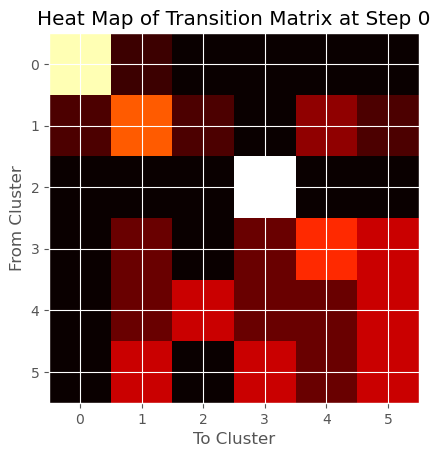

In [61]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.clf()
fig, ax = plt.subplots()
im = ax.imshow(transition_test[0], cmap='hot', interpolation='nearest')
def update(frame):
    im.set_data(transition_test[frame])
    ax.set_title(f'Heat Map of Transition Matrix at Step {frame}')
    ax.set_xlabel('To Cluster')
    ax.set_ylabel('From Cluster')
    return im
ani = animation.FuncAnimation(fig=fig, func=update, frames=len(transition_test), interval=1)
ani.save(filename="cluster_evolution.gif", writer="pillow")